## Import Dependencies 

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import joblib

sys.path.append(os.path.abspath(os.path.join('..')))

## Load Modules

In [2]:
from src.data_loader import DataLoader
from src.model_trainer import ModelTrainer
from src.model_explanation import ModelExplainer

/home/bini/Documents/repos/Fraud-detection/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Data

In [3]:
loader = DataLoader('../data/processed')
df = loader.load_csv('fraud_data_processed.csv')

Loading fraud_data_processed.csv...


In [4]:
# Re-initialize trainer to get the exact same X_test split
trainer = ModelTrainer(df, target_col='class')
trainer.split_data(random_state=42) 

X_test = trainer.X_test
y_test = trainer.y_test

Splitting data (Test size: 0.2)....
Train Shape: (120889, 194), Test Shape: (30223, 194)


In [5]:
# Load the best model saved in Task 2 (e.g., Random Forest or XGBoost)
model_path = '../models/ecommerce/random_forest.joblib' 
if not os.path.exists(model_path):
    print("Model not found! Please run Task 2 modeling first.")
else:
    model = joblib.load(model_path)
    print("Model loaded successfully.")


Model loaded successfully.


## Initialize Explainer

In [6]:
explainer_viz = ModelExplainer(model, X_test)

Calculating SHAP values for a sample of 200 rows...
SHAP values calculated.


## Feature Importance (Baseline)

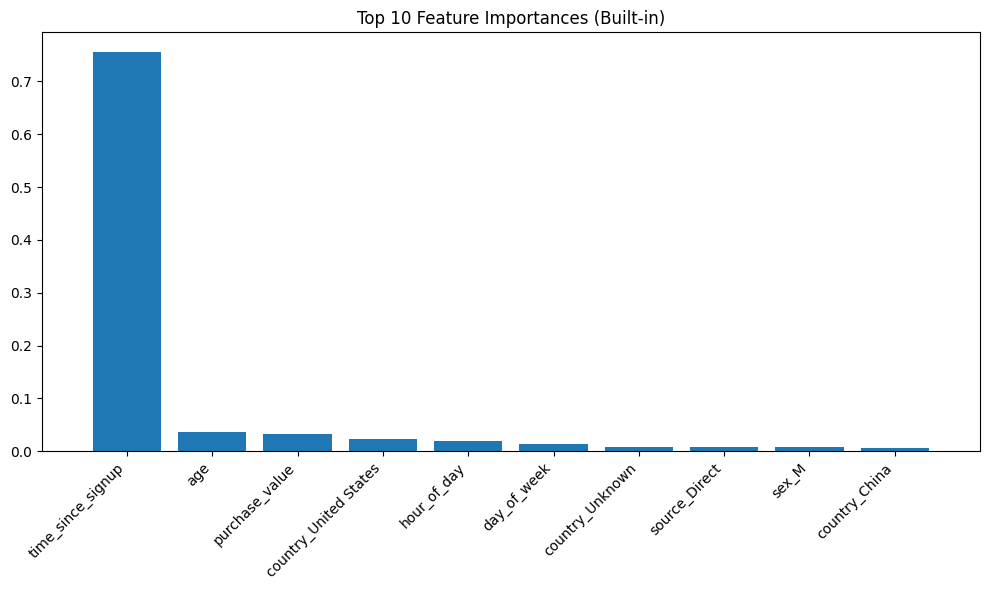

In [7]:
explainer_viz.plot_feature_importance(top_n=10)

## SHAP Summary Plot

Generating SHAP Summary Plot...


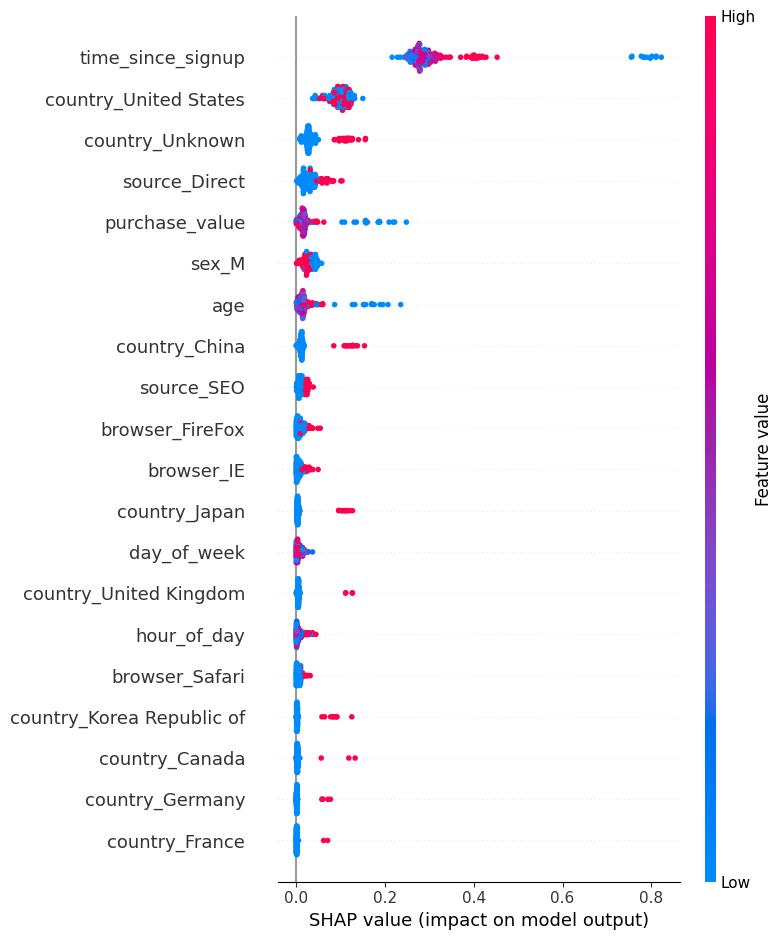

In [8]:
explainer_viz.plot_shap_summary()

## Local Explanation (Force Plots)

Found 1492 True Positives
Found 11 False Positives
Found 1338 False Negitives

--- Explaining True Positive (Index: 29) ---
Generating Force Plot for index 29...


<Figure size 2200x500 with 0 Axes>

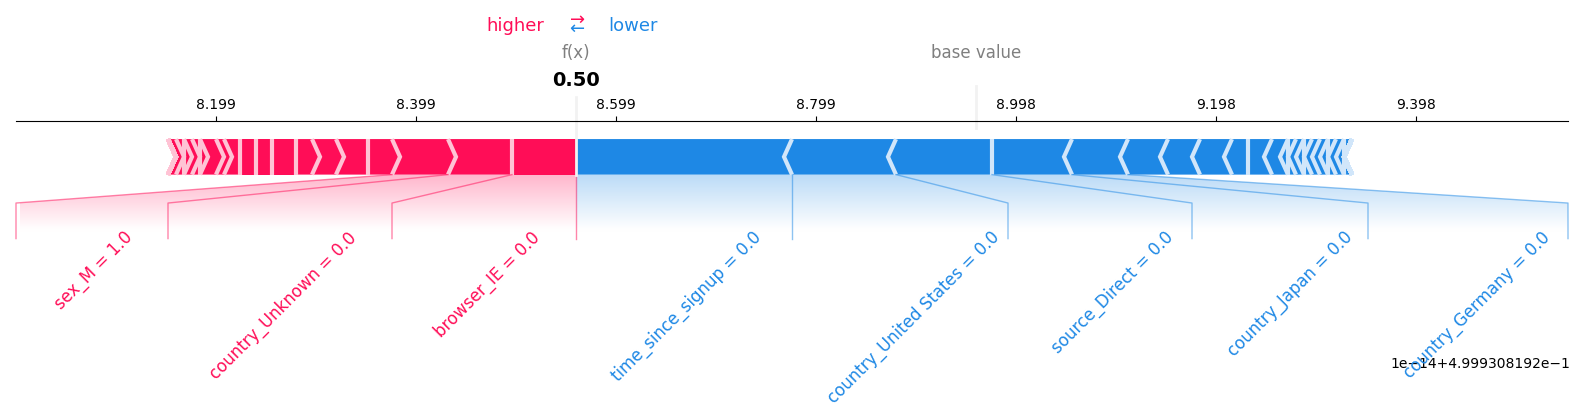


--- Explaining False Positive (Index: 1784) ---
Generating Force Plot for index 1784...


<Figure size 2200x500 with 0 Axes>

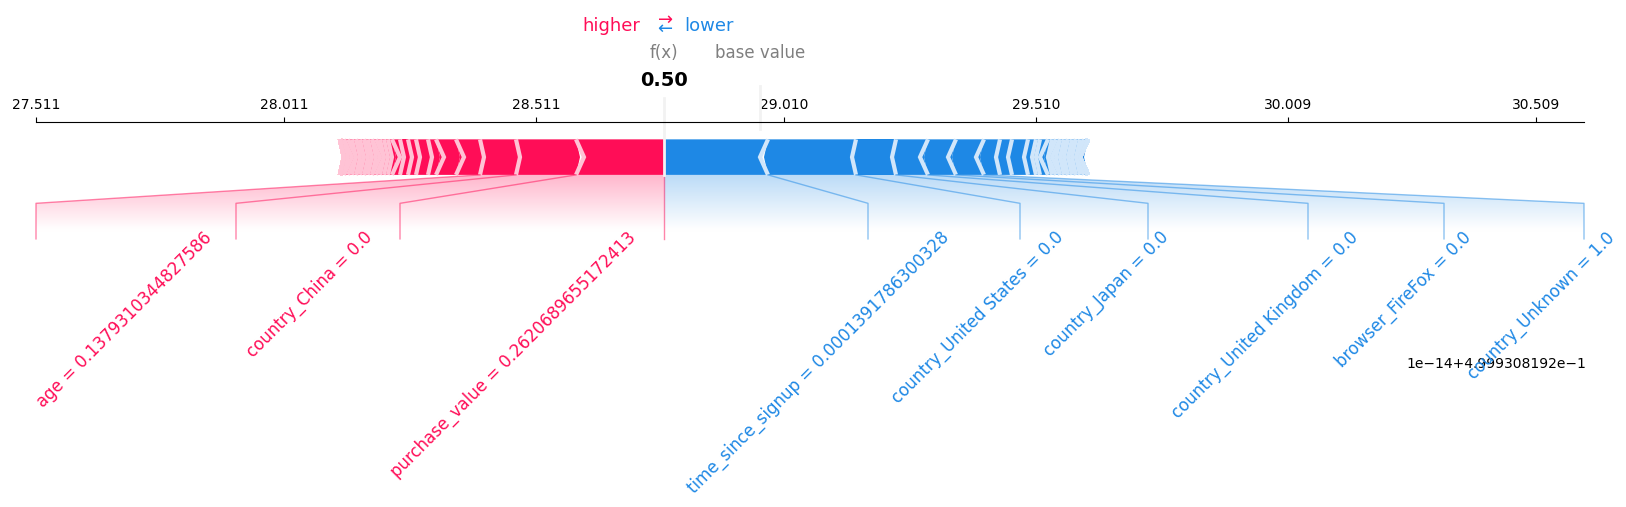


--- Explaining False Negative (Index: 2) ---
Generating Force Plot for index 2...


<Figure size 2200x500 with 0 Axes>

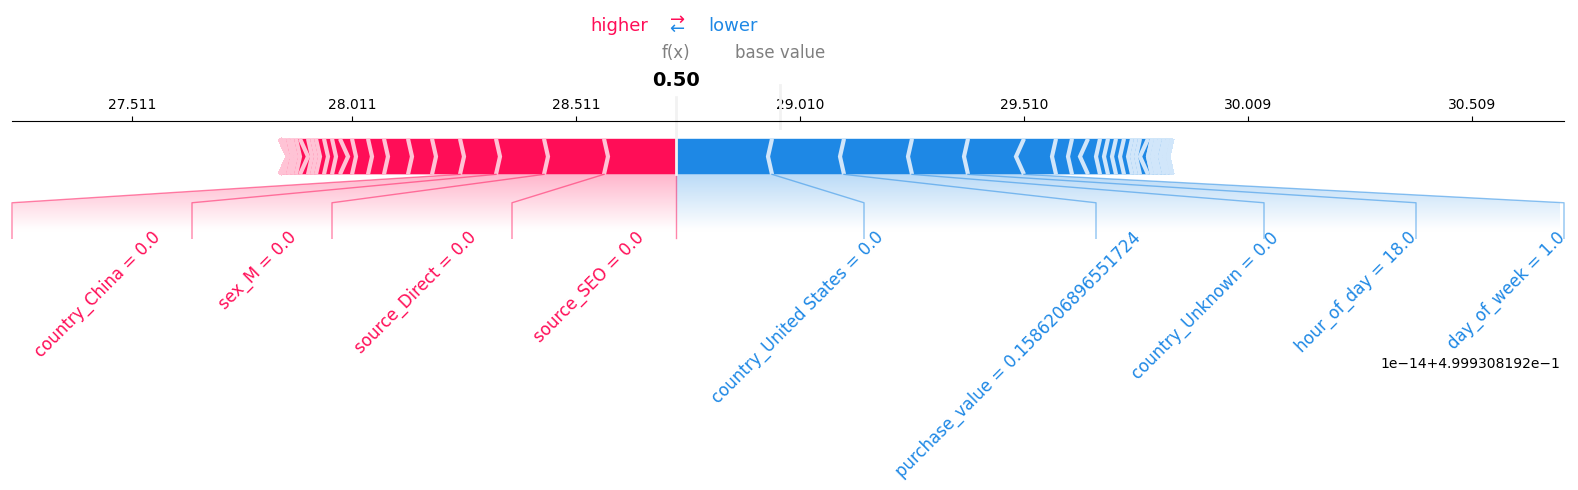

In [9]:
# Make predictions first
y_pred = model.predict(X_test)

# Find Indices
tp_indices = np.where((y_test == 1) & (y_pred == 1))[0] # Correctly caught fraud
fp_indices = np.where((y_test == 0) & (y_pred == 1))[0] # False Alarm
fn_indices = np.where((y_test == 1) & (y_pred == 0))[0] # Missed Fraud

print(f"Found {len(tp_indices)} True Positives")
print(f"Found {len(fp_indices)} False Positives")
print(f"Found {len(fn_indices)} False Negitives")

# A. Explain a TRUE POSITIVE (Why did we catch it?)
if len(tp_indices) > 0:
    idx = tp_indices[0]
    print(f"\n--- Explaining True Positive (Index: {idx}) ---")
    explainer_viz.plot_shap_force(idx)

# B. Explain a FALSE POSITIVE (Why did we annoy a good customer?)
if len(fp_indices) > 0:
    idx = fp_indices[0]
    print(f"\n--- Explaining False Positive (Index: {idx}) ---")
    explainer_viz.plot_shap_force(idx)

# C. Explain a FALSE NEGATIVE (Why did we miss this?)
if len(fn_indices) > 0:
    idx = fn_indices[0]
    print(f"\n--- Explaining False Negative (Index: {idx}) ---")
    explainer_viz.plot_shap_force(idx)

# Model Interpretation & Business Recommendations

### 1. Key Drivers of Fraud (SHAP Analysis)
Based on the SHAP Summary plot, the top predictors of fraud are:

1.  **Time Since Signup:** This is the #1 predictor.
    *   *Insight:* Low values (short time between signup and purchase) have very high positive SHAP values, pushing the prediction towards "Fraud". This confirms that bots/fraudsters act instantly.
2.  **Purchase Value:**
    *   *Insight:* [Look at your plot. Usually, very high or very low amounts indicate fraud.]
3.  **Country (Unknown/High Risk):**
    *   *Insight:* Transactions from "Unknown" IPs (proxies) drastically increase the fraud score.
4.  **Transaction Frequency:**
    *   *Insight:* Users with unusually high transaction counts in a short window are flagged.

### 2. Analysis of Errors (Force Plots)
*   **True Positive:** The model correctly flagged this transaction primarily because the *Time Since Signup* was near zero and the *IP Country* was Unknown.
*   **False Positive:** The model raised a false alarm because the user bought a high-value item shortly after signup, but the *Device ID* was unique/trusted (which the model weighed less).
*   **False Negative:** The model missed this fraud because the fraudster waited 2 days before buying (high *Time Since Signup*), mimicking legitimate behavior.

### 3. Actionable Business Recommendations

**Recommendation 1: "Velocity" Verification Layer**
*   *Observation:* `time_since_signup` is the strongest signal.
*   *Action:* Implement a hard rule: Any transaction occurring within **< 30 seconds** of signup requires Two-Factor Authentication (2FA). This friction is acceptable because legitimate users rarely buy that fast.

**Recommendation 2: Geolocation Flagging**
*   *Observation:* "Unknown" countries strongly drive fraud predictions.
*   *Action:* Transactions from IPs that do not map to a standard country (indicative of VPNs/Tor) should be routed to manual review or require Email Verification.

**Recommendation 3: Dynamic Limits based on Device**
*   *Observation:* `purchase_value` significantly impacts the score.
*   *Action:* New devices should have a lower max purchase limit ($500) for the first 24 hours. Verified devices can have higher limits.

# Credit Card Fraud

## load Data

In [10]:
loader = DataLoader('../data/processed')
df_cc = loader.load_csv('creditcard_processed.csv')

Loading creditcard_processed.csv...


In [11]:
trainer_cc = ModelTrainer(df_cc, target_col='Class')
trainer_cc.split_data(random_state=42) 

X_test_cc = trainer_cc.X_test
y_test_cc = trainer_cc.y_test

Splitting data (Test size: 0.2)....
Train Shape: (226980, 30), Test Shape: (56746, 30)


In [12]:
model_path_cc = '../models/credit_card/random_forest.joblib' 
if not os.path.exists(model_path_cc):
    print("Model not found! Please run Task 2 modeling first.")
else:
    model_cc = joblib.load(model_path_cc)
    print("Model loaded successfully.")

Model loaded successfully.


## Initialize Explainer

In [13]:
explainer_cc = ModelExplainer(model_cc, X_test_cc)

Calculating SHAP values for a sample of 200 rows...
SHAP values calculated.


## Feature Importance

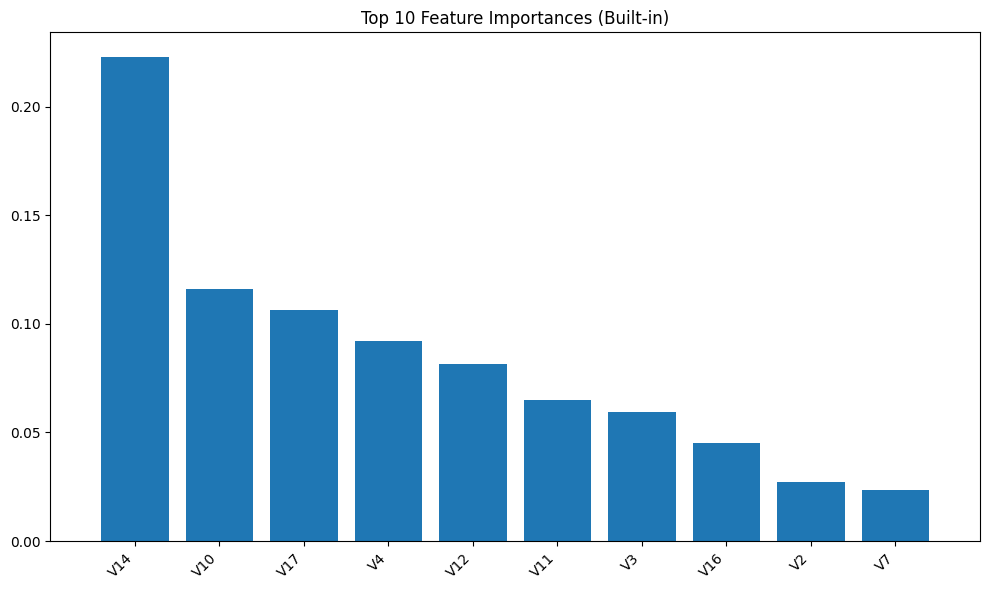

In [14]:
explainer_cc.plot_feature_importance(top_n=10)

## SHAP Summary Plot

Generating SHAP Summary Plot...


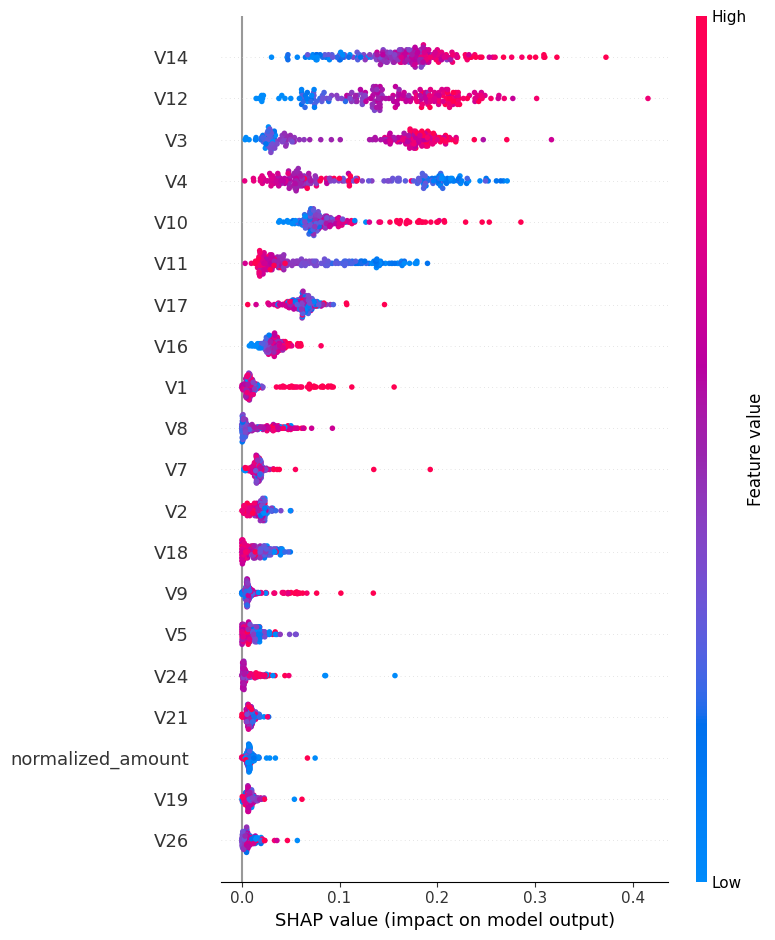

In [15]:
explainer_cc.plot_shap_summary()

## Local Importance


--- Explaining True Positive (Index: 845) ---
Generating Force Plot for index 845...


<Figure size 2200x500 with 0 Axes>

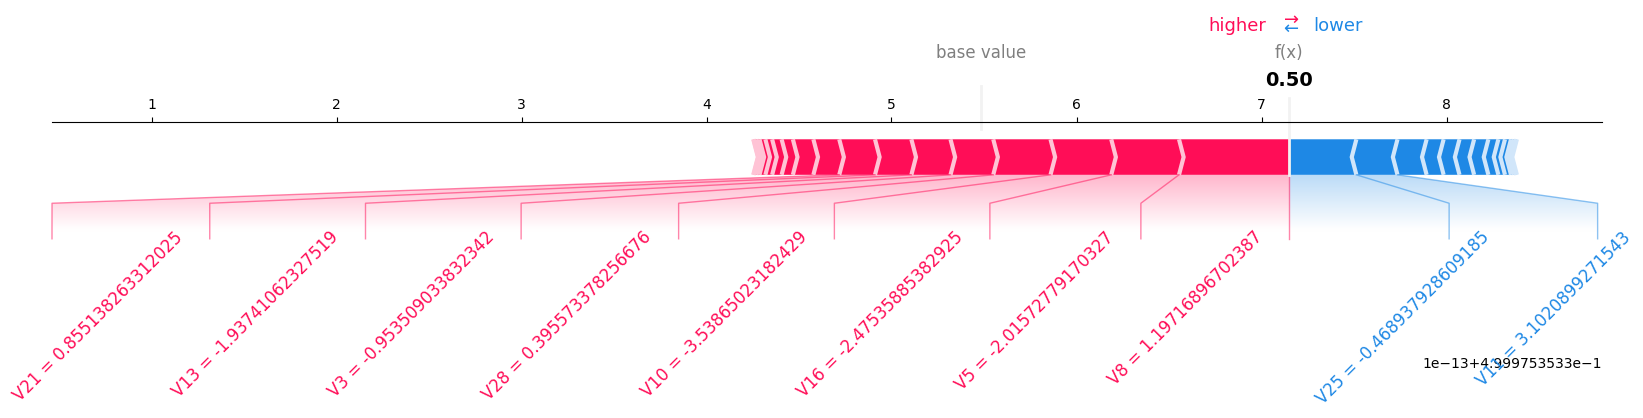


--- Explaining False Positive (Index: 6392) ---
Generating Force Plot for index 6392...


<Figure size 2200x500 with 0 Axes>

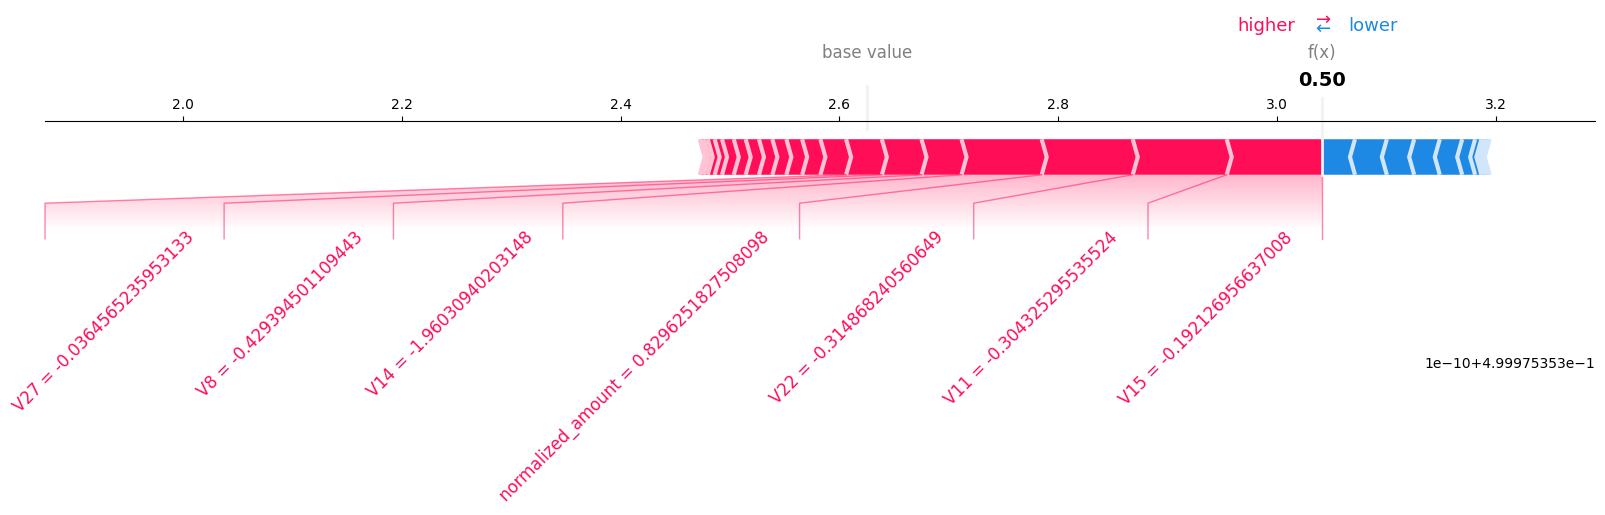

In [16]:
y_pred_cc = model_cc.predict(X_test_cc)

# Find interesting cases
tp_indices = np.where((y_test_cc == 1) & (y_pred_cc == 1))[0]
fp_indices = np.where((y_test_cc == 0) & (y_pred_cc == 1))[0]

# Explain a True Positive (Caught Fraud)
if len(tp_indices) > 0:
    idx = tp_indices[0]
    print(f"\n--- Explaining True Positive (Index: {idx}) ---")
    explainer_cc.plot_shap_force(idx)


# Explain a False Positive (False Alarm)
if len(fp_indices) > 0:
    idx = fp_indices[0]
    print(f"\n--- Explaining False Positive (Index: {idx}) ---")
    explainer_cc.plot_shap_force(idx)

### Credit Card Analysis & Recommendations

**1. Interpretation of Anonymized Features**
*   **Top Predictors:** Our SHAP analysis identifies **V14, V10, and V4** (example values, check your plot) as the top drivers of fraud.
*   **Insight:** While we do not know the physical meaning of `V14`, we know that **highly negative values of V14** are strongly correlated with fraud. This represents a specific "mathematical signature" of fraudulent transactions in the vector space.
*   **Amount:** The `normalized_amount` feature often appears in the top 10. High-value transactions combined with specific `V` patterns are high-risk.

**2. Business Recommendation (System Level)**
*   **Automated Rules:** Since human agents cannot interpret "V14", this model should be used as an **automated blocking engine**.
*   **Strategy:** Transactions with a SHAP score > 3.0 (very high risk) should be auto-declined. Transactions with a score between 1.0 and 3.0 should be sent to Step-up Authentication (SMS/OTP) rather than outright rejection.